In [ ]:
#Building fasttext for python\
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText
!pip3 install .

#Data Preparation

location of data: https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/data?select=Sarcasm_Headlines_Dataset_v2.json

In [46]:
#load data
import pandas as pd
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df = df.sample(frac=1).reset_index(drop=True)
# show first few rows
df.head()


,is_sarcastic,headline,article_link
0,1,school friends don't find camp songs funny,https://www.theonion.com/school-friends-dont-f...
1,0,what cutting americorps would mean for public ...,https://www.huffingtonpost.com/entry/what-cutt...
2,0,when our tears become medicine,https://www.huffingtonpost.com/entry/when-our-...
3,1,craig kilborn weds self in private ceremony,https://entertainment.theonion.com/craig-kilbo...
4,1,white couple admires fall colors,https://www.theonion.com/white-couple-admires-...


In [47]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [51]:
#utility for data inspection
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def plot_wordcloud(headlines, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))
    wc = WordCloud(background_color ='white',
                   min_font_size = 12)
    wc = wc.generate(headlines)
    plt.axis('off')
    plt.imshow(wc)

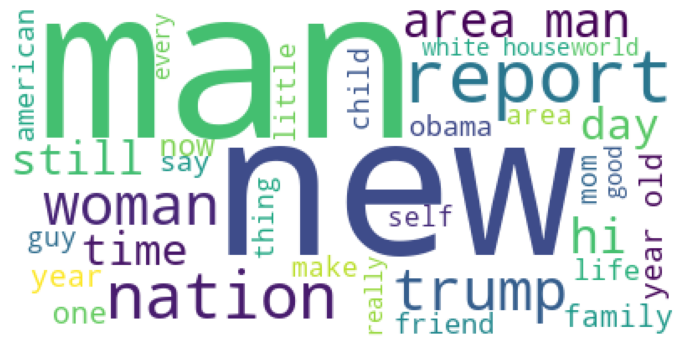

In [52]:
#word cloud on sarcastic headlines
sarcastic = ' '.join(df[df['is_sarcastic']==1]['headline'].to_list())
plot_wordcloud(sarcastic, 'Reds')

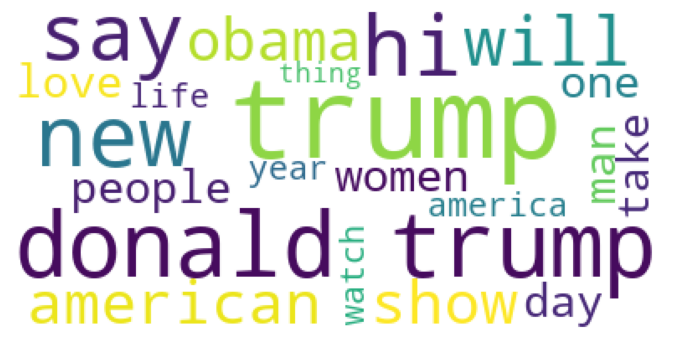

In [53]:
#word cloud on sarcastic headlines
sarcastic = ' '.join(df[df['is_sarcastic']==0]['headline'].to_list())
plot_wordcloud(sarcastic, 'Reds')

In [54]:
#DATA CLEANING  

#Since these are the headlines of news not much cleaning needed here I believe

# removing non alphanumeric character
import re
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

def replace_num(text):
    return re.sub(r'[0-9]', ' _NUM_ ', text)

df['headline'] = df['headline'].str.lower()
df['headline'] = df['headline'].apply(alpha_num)
df['headline'] = df['headline'].apply(replace_num)
df.head()

,is_sarcastic,headline,article_link
0,1,school friends dont find camp songs funny,https://www.theonion.com/school-friends-dont-f...
1,0,what cutting americorps would mean for public ...,https://www.huffingtonpost.com/entry/what-cutt...
2,0,when our tears become medicine,https://www.huffingtonpost.com/entry/when-our-...
3,1,craig kilborn weds self in private ceremony,https://entertainment.theonion.com/craig-kilbo...
4,1,white couple admires fall colors,https://www.theonion.com/white-couple-admires-...


In [55]:
#data preparation for fasttext
with open('fasttext_input_sarcastic_comments.txt', 'w') as f:
    for each_text, each_label in zip(df['headline'], df['is_sarcastic']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [56]:
!head -n 10 fasttext_input_sarcastic_comments.txt

__label__1 school friends dont find camp songs funny
__label__0 what cutting americorps would mean for public lands
__label__0 when our tears become medicine
__label__1 craig kilborn weds self in private ceremony
__label__1 white couple admires fall colors
__label__1 mom much more insistent about getting grandkids from one child than other
__label__0 diary of a queer kids mom
__label__1 sephora makeup artist helping woman create the perfect pink eye
__label__1 kelloggs pulls controversial chocobastard from store shelves
__label__0 winston churchills grandson introduces a new nickname for donald trump


In [57]:
!wc fasttext_input_sarcastic_comments.txt

28619  321984 2153211 fasttext_input_sarcastic_comments.txt


In [59]:
28619 * .9

25757.100000000002

In [60]:
28619 - 25757

2862

In [62]:
!head -n 25757 fasttext_input_sarcastic_comments.txt > sarcasm_train.bin

In [63]:
!tail -n 2862 fasttext_input_sarcastic_comments.txt > sarcasm_test.bin

In [64]:
#MODEL TRAINING AND PERFORMANCE

In [65]:
import fasttext

In [73]:
'''
For classification train_supervised call will be used:

The default parameters to it:
    input             # training file path (required)
    lr                # learning rate [0.1]
    dim               # size of word vectors [100]
    ws                # size of the context window [5]
    epoch             # number of epochs [5]
    minCount          # minimal number of word occurences [1]
    minCountLabel     # minimal number of label occurences [1]
    minn              # min length of char ngram [0]
    maxn              # max length of char ngram [0]
    neg               # number of negatives sampled [5]
    wordNgrams        # max length of word ngram [1]
    loss              # loss function {ns, hs, softmax, ova} [softmax]
    bucket            # number of buckets [2000000]
    thread            # number of threads [number of cpus]
    lrUpdateRate      # change the rate of updates for the learning rate [100]
    t                 # sampling threshold [0.0001]
    label             # label prefix ['__label__']
    verbose           # verbose [2]
    pretrainedVectors # pretrained word vectors (.vec file) for supervised learning []
'''
model = fasttext.train_supervised('sarcasm_train.bin', wordNgrams=2)

In [74]:
#measuring performance on test data
def print_results(sample_size, precision, recall):
    precision   = round(precision, 2)
    recall      = round(recall, 2)
    print(f'{sample_size=}')
    print(f'{precision=}')
    print(f'{recall=}')

print_results(*model.test('sarcasm_test.bin'))

sample_size=2862
precision=0.86
recall=0.86


In [76]:
#save the model
model.save_model('fasttext_sarcasm.model')

In [ ]:
#MODEL COMPRESS

# with the previously trained `model` object, call :
model.quantize(input='sarcasm_train.bin', retrain=True)

# then display results and save the new model :
print_results(*model.test('sarcasm_test.bin'))

In [77]:
!ls

fasttext_input_sarcastic_comments.txt  Sarcasm_Headlines_Dataset_v2.json
fasttext.ipynb			       sarcasm_test.bin
fasttext_sarcasm.model		       sarcasm_train.bin
